In [75]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt

%matplotlib inline
from sklearn.mixture import GaussianMixture
#run kmeans and gaussian and interpret, keep how many clusters i need and change
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from scipy.special import entr


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/Gaukhar-ai/for_my_Thinkful_work/master/capstone/Stock%20Market_1B_predictions/stock_market_data.csv')
df.head()

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
0,ZYME,8269000.0,3.091,9007000.0,636578000.0,-3.765,-37487000.0,48686718.0,0.170,-35880000.0,...,-162932000.0,-2.154,3.091,-0.358217,-4.339097835,-0.823549,0.181661,-16.467038,6.807722,0.014149
1,ZYME,1877000.0,7.288,6881000.0,368205000.0,-38.489,-36354000.0,43658717.0,0.043,-73752000.0,...,-145437000.0,-2.319,7.288,-0.409374,-39.29248801,-0.922987,0.047655,-19.603277,3.647265,0.018688
2,ZYME,7860000.0,3.146,6755000.0,400037000.0,-3.877,-10880000.0,43445379.0,0.181,-33564000.0,...,-63920000.0,0.004,3.146,-0.197080,-4.270229008,-0.277127,0.200204,6200.000000,6.678431,0.016886
3,ZYME,7882000.0,2.112,7829000.0,414547000.0,-3.689,-13317000.0,32837975.0,0.240,-29432000.0,...,-52196000.0,0.028,2.112,-0.191239,-3.734077645,-0.415356,0.245839,785.714286,8.874183,0.018886
4,ZYME,11925000.0,3.048,8065000.0,238279000.0,-1.144,-21302000.0,32020437.0,0.372,-14553000.0,...,-28993000.0,0.616,3.048,-0.130571,-1.220377358,-0.665162,0.372362,26.266234,6.440652,0.033847


In [50]:
df_original = df.copy()

In [3]:
df.shape

(40277, 31)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40277 entries, 0 to 40276
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ticker                   40277 non-null  object 
 1   revenue                  39949 non-null  float64
 2   pb                       38433 non-null  float64
 3   debt                     39416 non-null  float64
 4   assets                   39416 non-null  float64
 5   netmargin                38980 non-null  float64
 6   ncfo                     39683 non-null  float64
 7   shareswa                 40072 non-null  float64
 8   sps                      39800 non-null  float64
 9   opinc                    39949 non-null  float64
 10  assetsc                  30302 non-null  float64
 11  liabilitiesc             30265 non-null  float64
 12  price                    38513 non-null  float64
 13  calendardate             40277 non-null  object 
 14  datekey               

In [5]:
df['datekey'].nunique()

584

In [6]:
(df['datekey'] == df['calendardate']).mean() # 83% they match. 


0.8301015467884897

In [7]:
df['calendardate'].unique() #'12/31/2019', '9/30/2019' pick this quarter, merge by Ticker
#add next quarters price. compute the return 

array(['3/31/2020', '12/31/2019', '9/30/2019', '6/30/2019', '3/31/2019',
       '12/31/2018', '9/30/2018', '6/30/2018', '3/31/2018', '12/31/2017',
       '9/30/2017', '6/30/2017', '3/31/2017', '12/31/2016', '12/31/2015',
       '9/30/2016', '6/30/2016', '3/31/2016', '9/30/2015', '6/30/2015',
       '3/31/2015', '6/30/2020'], dtype=object)

In [8]:
#df['calendardate'].unique()

In [9]:
df['calendardate'] = pd.to_datetime(df['calendardate'])
df.head()

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
0,ZYME,8269000.0,3.091,9007000.0,636578000.0,-3.765,-37487000.0,48686718.0,0.170,-35880000.0,...,-162932000.0,-2.154,3.091,-0.358217,-4.339097835,-0.823549,0.181661,-16.467038,6.807722,0.014149
1,ZYME,1877000.0,7.288,6881000.0,368205000.0,-38.489,-36354000.0,43658717.0,0.043,-73752000.0,...,-145437000.0,-2.319,7.288,-0.409374,-39.29248801,-0.922987,0.047655,-19.603277,3.647265,0.018688
2,ZYME,7860000.0,3.146,6755000.0,400037000.0,-3.877,-10880000.0,43445379.0,0.181,-33564000.0,...,-63920000.0,0.004,3.146,-0.197080,-4.270229008,-0.277127,0.200204,6200.000000,6.678431,0.016886
3,ZYME,7882000.0,2.112,7829000.0,414547000.0,-3.689,-13317000.0,32837975.0,0.240,-29432000.0,...,-52196000.0,0.028,2.112,-0.191239,-3.734077645,-0.415356,0.245839,785.714286,8.874183,0.018886
4,ZYME,11925000.0,3.048,8065000.0,238279000.0,-1.144,-21302000.0,32020437.0,0.372,-14553000.0,...,-28993000.0,0.616,3.048,-0.130571,-1.220377358,-0.665162,0.372362,26.266234,6.440652,0.033847


In [10]:
df['calendardate']

0       2020-03-31
1       2019-12-31
2       2019-09-30
3       2019-06-30
4       2019-03-31
           ...    
40272   2016-03-31
40273   2015-12-31
40274   2015-09-30
40275   2015-06-30
40276   2015-03-31
Name: calendardate, Length: 40277, dtype: datetime64[ns]

In [11]:
df = df[df['calendardate'].between('2019-10-01', '2020-01-01')]
df.head()

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
1,ZYME,1.877000e+06,7.288,6.881000e+06,3.682050e+08,-38.489,-36354000.0,43658717.0,0.043,-73752000.0,...,-1.454370e+08,-2.319,7.288,-0.409374,-39.29248801,-0.922987,0.047655,-19.603277,3.647265,0.018688
16,ZUO,7.039300e+07,10.140,7.858800e+07,4.022270e+08,-0.337,4009000.0,113180000.0,0.622,-24449000.0,...,-8.339400e+07,-0.225,10.140,-0.243414,-0.347321467,0.035415,0.621846,-65.555556,1.454003,0.195382
30,ZTS,1.674000e+09,23.279,6.611000e+09,1.154500e+10,0.229,582000000.0,476412000.0,3.514,493000000.0,...,1.500000e+09,2.792,23.279,0.134270,0.294504182,1.221921,3.514597,47.403295,1.672204,0.572629
51,ZS,1.012680e+08,22.487,3.444200e+07,6.764250e+08,-0.288,5431000.0,128408000.0,0.789,-30280000.0,...,-6.374200e+07,0.153,22.487,-0.103884,-0.299008571,0.042444,0.791419,366.601307,1.579705,0.050918
65,ZNGA,4.044630e+08,2.931,7.165100e+08,3.660614e+09,-0.009,94049000.0,947733000.0,0.427,4332000.0,...,4.192500e+07,0.873,2.931,0.012826,0.010710498,0.099426,0.427586,7.010309,1.933891,0.195735


In [12]:
df['OPER_MARGIN'] = pd.to_numeric(df['OPER_MARGIN'],errors='coerce') #errors = 'coerse' - converts to NA


In [13]:
df[df['ticker'].isin(['AMD', 'BA', 'GE', 'HTZ', 'AAL', 'NCLH', 'JILL', 'INTEQ'])] #can drop quick_ratio or drop HTZ, GE

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
15741,NCLH,1.480618e+09,1.907,6.801693e+09,1.668460e+10,0.082,3.418510e+08,2.128776e+08,6.955,1.993760e+08,...,9.302280e+08,0.863,1.907,0.057823,0.134657,1.606763,6.959180,67.682503,0.091504,0.407663
22792,HTZ,2.325000e+09,1.265,1.893700e+10,2.462700e+10,-0.051,6.670000e+08,1.170000e+08,19.872,8.900000e+07,...,-5.800000e+07,-13.034,1.265,-0.002307,0.038280,4.693162,16.359223,-1.208378,NaN,0.768953
25128,GE,1.573700e+10,3.442,9.088200e+10,2.660480e+11,0.034,6.739000e+09,8.733549e+09,1.802,2.186000e+09,...,-5.439000e+09,0.732,3.442,-0.018816,0.138908,0.771622,1.801902,15.245902,NaN,0.341600
36147,BA,1.791100e+10,-21.276,2.730200e+10,1.336250e+11,-0.056,-2.220000e+09,5.627912e+08,31.825,-2.599000e+09,...,-6.360000e+08,-7.011,-21.276,-0.004962,-0.145106,-3.944624,31.825300,-46.464128,0.253175,0.204318
38187,AMD,2.127000e+09,18.191,6.850000e+08,6.028000e+09,0.080,4.420000e+08,1.139000e+09,1.867,3.480000e+08,...,3.410000e+08,0.253,18.191,0.063995,0.163611,0.396901,1.909974,182.529644,1.425180,0.113636
40217,AAL,1.131300e+10,-106.470,3.344400e+10,5.999500e+10,0.037,6.000000e+08,4.380580e+08,25.825,7.290000e+08,...,1.686000e+09,-0.911,-106.470,0.027648,0.064439,1.369682,25.825349,-31.481888,0.313145,0.557446


In [14]:
df = df.replace([np.inf, -np.inf], np.nan)


In [15]:

df = df.dropna()

In [16]:
df.info() #check for infinity how many rows where dropped

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1493 entries, 1 to 40257
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ticker                   1493 non-null   object        
 1   revenue                  1493 non-null   float64       
 2   pb                       1493 non-null   float64       
 3   debt                     1493 non-null   float64       
 4   assets                   1493 non-null   float64       
 5   netmargin                1493 non-null   float64       
 6   ncfo                     1493 non-null   float64       
 7   shareswa                 1493 non-null   float64       
 8   sps                      1493 non-null   float64       
 9   opinc                    1493 non-null   float64       
 10  assetsc                  1493 non-null   float64       
 11  liabilitiesc             1493 non-null   float64       
 12  price                    1493 non

In [17]:
df[df['ticker'].isin(['AMD', 'BA', 'GE', 'HTZ', 'AAL', 'NCLH', 'JILL', 'INTEQ'])]

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
15741,NCLH,1.480618e+09,1.907,6.801693e+09,1.668460e+10,0.082,3.418510e+08,2.128776e+08,6.955,1.993760e+08,...,9.302280e+08,0.863,1.907,0.057823,0.134657,1.606763,6.959180,67.682503,0.091504,0.407663
36147,BA,1.791100e+10,-21.276,2.730200e+10,1.336250e+11,-0.056,-2.220000e+09,5.627912e+08,31.825,-2.599000e+09,...,-6.360000e+08,-7.011,-21.276,-0.004962,-0.145106,-3.944624,31.825300,-46.464128,0.253175,0.204318
38187,AMD,2.127000e+09,18.191,6.850000e+08,6.028000e+09,0.080,4.420000e+08,1.139000e+09,1.867,3.480000e+08,...,3.410000e+08,0.253,18.191,0.063995,0.163611,0.396901,1.909974,182.529644,1.425180,0.113636
40217,AAL,1.131300e+10,-106.470,3.344400e+10,5.999500e+10,0.037,6.000000e+08,4.380580e+08,25.825,7.290000e+08,...,1.686000e+09,-0.911,-106.470,0.027648,0.064439,1.369682,25.825349,-31.481888,0.313145,0.557446


In [18]:
#df['calendardate']
df.head()

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
1,ZYME,1.877000e+06,7.288,6.881000e+06,3.682050e+08,-38.489,-36354000.0,43658717.0,0.043,-73752000.0,...,-1.454370e+08,-2.319,7.288,-0.409374,-39.292488,-0.922987,0.047655,-19.603277,3.647265,0.018688
16,ZUO,7.039300e+07,10.140,7.858800e+07,4.022270e+08,-0.337,4009000.0,113180000.0,0.622,-24449000.0,...,-8.339400e+07,-0.225,10.140,-0.243414,-0.347321,0.035415,0.621846,-65.555556,1.454003,0.195382
30,ZTS,1.674000e+09,23.279,6.611000e+09,1.154500e+10,0.229,582000000.0,476412000.0,3.514,493000000.0,...,1.500000e+09,2.792,23.279,0.134270,0.294504,1.221921,3.514597,47.403295,1.672204,0.572629
51,ZS,1.012680e+08,22.487,3.444200e+07,6.764250e+08,-0.288,5431000.0,128408000.0,0.789,-30280000.0,...,-6.374200e+07,0.153,22.487,-0.103884,-0.299009,0.042444,0.791419,366.601307,1.579705,0.050918
65,ZNGA,4.044630e+08,2.931,7.165100e+08,3.660614e+09,-0.009,94049000.0,947733000.0,0.427,4332000.0,...,4.192500e+07,0.873,2.931,0.012826,0.010710,0.099426,0.427586,7.010309,1.933891,0.195735


In [19]:
df_copy = df.copy() #can cluster labels in df copy for cluster analyses.

drop_cols = ['datekey', 'calendardate', 'TOT_DEBT_TO_TOTAL_ASSET', 'PX_FREE_CASH_FLOW', 'REVENUE_PER_SHARE', 'CASH_FLOW_PER_SHARE',
            'OPER_MARGIN', 'RETURN_ON_ASSET', 'PX_TO_BOOK_RATIO', 'ticker']
df.drop(columns = drop_cols, inplace=True)


In [20]:
df.isna().sum()

ticker                     0
revenue                    0
pb                         0
debt                       0
assets                     0
netmargin                  0
ncfo                       0
shareswa                   0
sps                        0
opinc                      0
assetsc                    0
liabilitiesc               0
price                      0
calendardate               0
datekey                    0
sharesbas                  0
equity                     0
receivables                0
investmentsc               0
cashneq                    0
assetsavg                  0
netinccmn                  0
fcfps                      0
PX_TO_BOOK_RATIO           0
RETURN_ON_ASSET            0
OPER_MARGIN                0
CASH_FLOW_PER_SHARE        0
REVENUE_PER_SHARE          0
PX_FREE_CASH_FLOW          0
quick_ratio                0
TOT_DEBT_TO_TOTAL_ASSET    0
dtype: int64

In [21]:
keep_cols = ['TOT_DEBT_TO_TOTAL_ASSET', 'PX_FREE_CASH_FLOW', 'REVENUE_PER_SHARE', 'CASH_FLOW_PER_SHARE',
            'OPER_MARGIN', 'RETURN_ON_ASSET', 'PX_TO_BOOK_RATIO', 'quick_ratio', 'equity', 'netmargin']
df=df[keep_cols]
df.head()

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,REVENUE_PER_SHARE,CASH_FLOW_PER_SHARE,OPER_MARGIN,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,equity,netmargin
1,0.018688,-19.603277,0.047655,-0.922987,-39.292488,-0.409374,7.288,3.647265,2.456810e+08,-38.489
16,0.195382,-65.555556,0.621846,0.035415,-0.347321,-0.243414,10.140,1.454003,1.646590e+08,-0.337
30,0.572629,47.403295,3.514597,1.221921,0.294504,0.134270,23.279,1.672204,2.708000e+09,0.229
51,0.050918,366.601307,0.791419,0.042444,-0.299009,-0.103884,22.487,1.579705,3.191640e+08,-0.288
65,0.195735,7.010309,0.427586,0.099426,0.010710,0.012826,2.931,1.933891,1.975430e+09,-0.009


In [22]:
df.head()


,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,REVENUE_PER_SHARE,CASH_FLOW_PER_SHARE,OPER_MARGIN,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,equity,netmargin
1,0.018688,-19.603277,0.047655,-0.922987,-39.292488,-0.409374,7.288,3.647265,2.456810e+08,-38.489
16,0.195382,-65.555556,0.621846,0.035415,-0.347321,-0.243414,10.140,1.454003,1.646590e+08,-0.337
30,0.572629,47.403295,3.514597,1.221921,0.294504,0.134270,23.279,1.672204,2.708000e+09,0.229
51,0.050918,366.601307,0.791419,0.042444,-0.299009,-0.103884,22.487,1.579705,3.191640e+08,-0.288
65,0.195735,7.010309,0.427586,0.099426,0.010710,0.012826,2.931,1.933891,1.975430e+09,-0.009


In [23]:
#find out what's the fastest way to find upper case and drop them.

In [25]:
df.corr()

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,REVENUE_PER_SHARE,CASH_FLOW_PER_SHARE,OPER_MARGIN,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,equity,netmargin
TOT_DEBT_TO_TOTAL_ASSET,1.000000,-0.009748,0.005964,0.021061,0.069597,0.094259,-0.045669,-0.169095,0.004443,0.066201
PX_FREE_CASH_FLOW,-0.009748,1.000000,-0.004659,-0.004172,0.006953,0.051876,0.011290,0.024979,-0.002127,0.006396
REVENUE_PER_SHARE,0.005964,-0.004659,1.000000,0.892506,0.011968,0.035092,-0.003294,-0.037426,0.815309,0.010660
CASH_FLOW_PER_SHARE,0.021061,-0.004172,0.892506,1.000000,0.021760,0.094722,-0.006566,-0.053225,0.889748,0.019044
OPER_MARGIN,0.069597,0.006953,0.011968,0.021760,1.000000,0.285012,-0.006289,-0.129486,0.002986,0.900705
RETURN_ON_ASSET,0.094259,0.051876,0.035092,0.094722,0.285012,1.000000,-0.017569,-0.133204,0.007883,0.258953
PX_TO_BOOK_RATIO,-0.045669,0.011290,-0.003294,-0.006566,-0.006289,-0.017569,1.000000,0.005273,-0.001863,-0.005069
quick_ratio,-0.169095,0.024979,-0.037426,-0.053225,-0.129486,-0.133204,0.005273,1.000000,-0.007829,-0.182241
equity,0.004443,-0.002127,0.815309,0.889748,0.002986,0.007883,-0.001863,-0.007829,1.000000,0.002667
netmargin,0.066201,0.006396,0.010660,0.019044,0.900705,0.258953,-0.005069,-0.182241,0.002667,1.000000


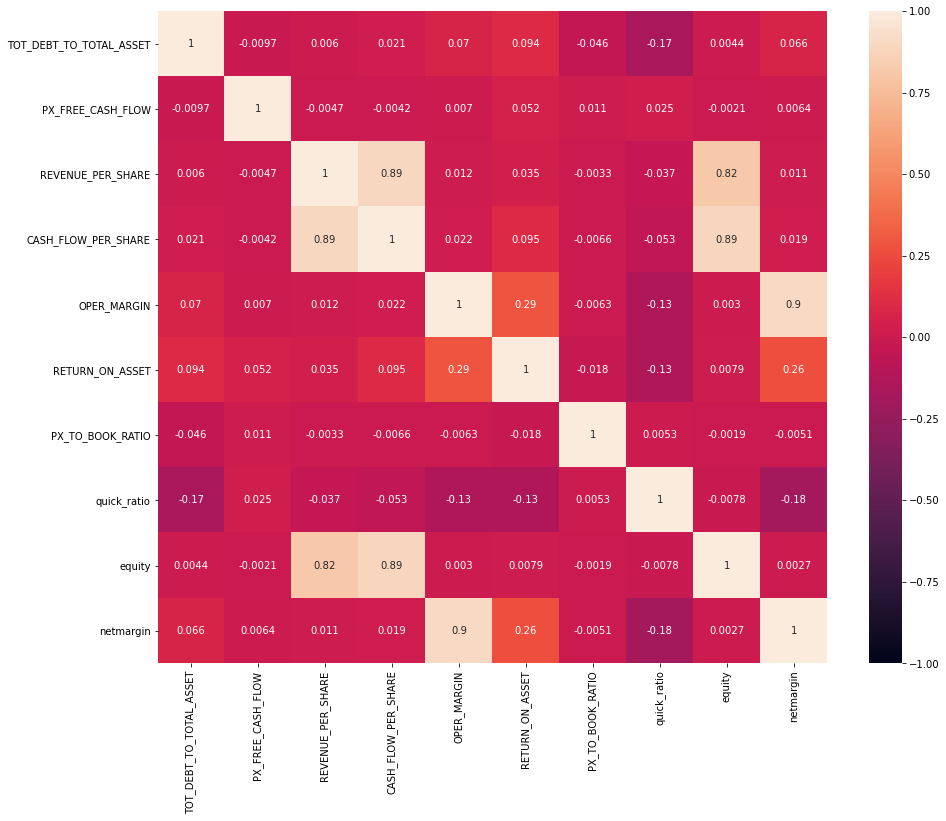

In [26]:
plt.figure(figsize=(15, 12))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

In [27]:
#>0.5 - higly corr
#< - 0.5 - highly reversely corr

In [28]:
 #new = df.drop(['A', 'B'], axis = 1) other way of saving it to a new var

In [29]:
drop_cols = ['equity', 'REVENUE_PER_SHARE']
df.drop(drop_cols, axis = 1, inplace=True)
df.head()

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,OPER_MARGIN,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,netmargin
1,0.018688,-19.603277,-0.922987,-39.292488,-0.409374,7.288,3.647265,-38.489
16,0.195382,-65.555556,0.035415,-0.347321,-0.243414,10.140,1.454003,-0.337
30,0.572629,47.403295,1.221921,0.294504,0.134270,23.279,1.672204,0.229
51,0.050918,366.601307,0.042444,-0.299009,-0.103884,22.487,1.579705,-0.288
65,0.195735,7.010309,0.099426,0.010710,0.012826,2.931,1.933891,-0.009


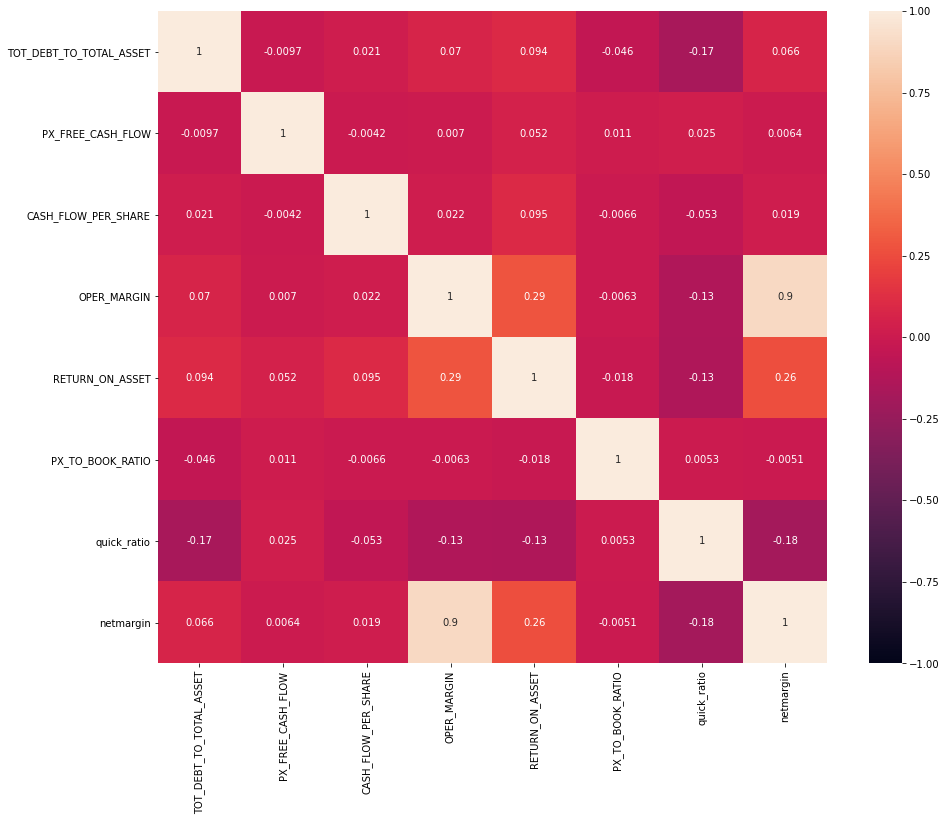

In [30]:
plt.figure(figsize=(15, 12))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

In [31]:
df.isin

<bound method DataFrame.isin of        TOT_DEBT_TO_TOTAL_ASSET  PX_FREE_CASH_FLOW  CASH_FLOW_PER_SHARE  \
1                     0.018688         -19.603277            -0.922987   
16                    0.195382         -65.555556             0.035415   
30                    0.572629          47.403295             1.221921   
51                    0.050918         366.601307             0.042444   
65                    0.195735           7.010309             0.099426   
...                        ...                ...                  ...   
40154                 0.245764          18.533474             2.286520   
40175                 0.000000          42.303082             0.524823   
40217                 0.557446         -31.481888             1.369682   
40238                 0.123026          13.004837             1.411844   
40257                 0.259131          42.732919            -0.190210   

       OPER_MARGIN  RETURN_ON_ASSET  PX_TO_BOOK_RATIO  quick_ratio  netmargin  

In [51]:
X = df.copy()
y = df_original["TOT_DEBT_TO_TOTAL_ASSET"]

In [52]:

scaler = StandardScaler()
X = scaler.fit_transform(df)

In [53]:
pca = PCA(2)
pca.fit(X)

PCA(n_components=2)

In [54]:
pca.explained_variance_ratio_
print(f"Total variance explained: {sum(pca.explained_variance_ratio_)*100:.2f}%")

Total variance explained: 40.96%


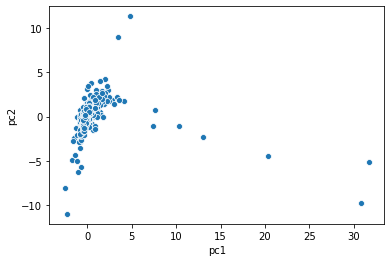

In [55]:
pc_df = pca.transform(X)
pc_df = pd.DataFrame(pc_df, columns=["pc1", "pc2"], index=df.index)

sns.scatterplot(x="pc1", y="pc2", data=pc_df)
plt.show()

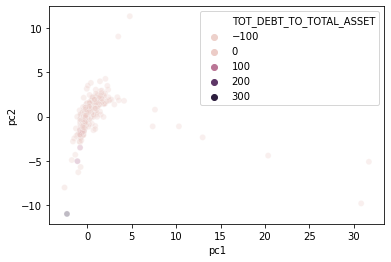

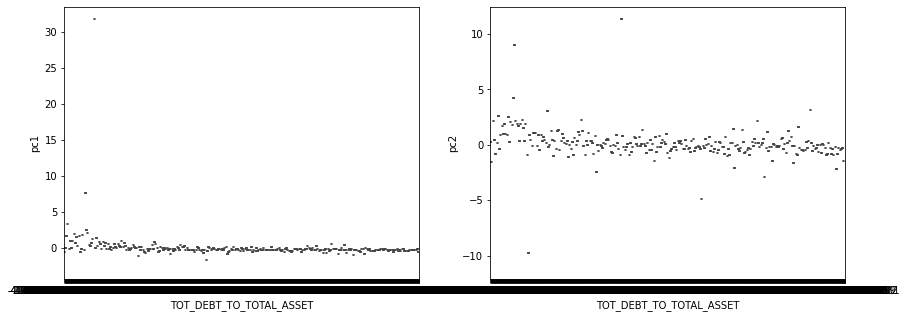

In [58]:
plot_df = pc_df.copy()
plot_df["TOT_DEBT_TO_TOTAL_ASSET"] = y

sns.scatterplot(x="pc1", y="pc2", hue="TOT_DEBT_TO_TOTAL_ASSET", alpha=0.3, data=plot_df)
plt.show()

fix, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.boxplot(x="TOT_DEBT_TO_TOTAL_ASSET", y="pc1", data=plot_df, ax=axes[0])
sns.boxplot(x="TOT_DEBT_TO_TOTAL_ASSET", y="pc2", data=plot_df, ax=axes[1])
plt.show()

In [66]:
kmeans = KMeans(n_clusters = 5, random_state=55)
kmeans.fit(X)
y_pred = kmeans.predict(X)
print(y_pred)

[3 3 0 ... 0 4 4]


In [72]:
kmeans = KMeans(n_clusters=5, random_state=55)
kmeans.fit(X)
pd.Series(kmeans.labels_).value_counts()


4    792
0    559
3    136
2      3
1      3
dtype: int64

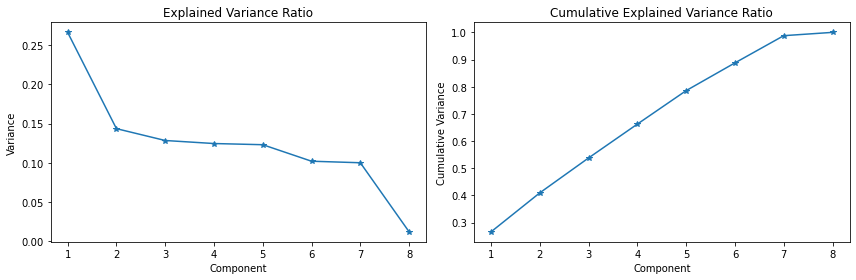

In [73]:
# creating more than 2 points for the plot
pca_8 = PCA(8).fit(X_std)

expl_var = pca_8.explained_variance_ratio_
cumulative_var = np.cumsum(expl_var)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(np.arange(1, 9), expl_var, "-*")
axes[0].set_title("Explained Variance Ratio")
axes[0].set_xlabel("Component")
axes[0].set_ylabel("Variance")

axes[1].plot(np.arange(1, 9), cumulative_var, "-*")
axes[1].set_title("Cumulative Explained Variance Ratio")
axes[1].set_xlabel("Component")
axes[1].set_ylabel("Cumulative Variance")

plt.tight_layout()
plt.show()

In [76]:

centroids = kmeans_cluster_centers_
centroids = scaler.inverse_transform(centroids)
centroids_df = pd.DataFrame(centroids, columns=df.columns)
centroids_df.style.background_gradient()

NameError: name 'kmeans_cluster_centers_' is not defined

In [79]:
gauss = GaussianMixture(n_components=3, random_state=55)
gauss.fit(X)

GaussianMixture(n_components=3, random_state=55)

In [80]:
gauss.means_

array([[-0.69087476,  0.01485564, -0.3166851 , -1.23231495, -2.14563588,
         0.09505253,  1.68065231, -1.09611919],
       [ 0.090902  , -0.00262567, -0.03386229,  0.06959519,  0.24936237,
        -0.0158466 , -0.2238322 ,  0.06165899],
       [-0.0863217 ,  0.00346024,  0.14098547,  0.06725982, -0.18932077,
         0.01986071,  0.21644431,  0.06041077]])

In [81]:
prob_df = pd.DataFrame(gauss.predict_proba(X))
prob_df.shape

(1493, 3)

In [82]:
import scipy 

In [83]:
scipy.stats.entropy([0.731826, 0.267606, 5.687710e-04])


0.5855042262910504

In [85]:
prob_df['entropy'] = prob_df.apply(scipy.stats.entropy, axis=1)

In [86]:
prob_df.sort_values('entropy')

,0,1,2,entropy
0,1.000000e+00,0.000000,0.000000,0.000000
824,1.000000e+00,0.000000,0.000000,0.000000
1476,1.000000e+00,0.000000,0.000000,0.000000
374,1.000000e+00,0.000000,0.000000,0.000000
1035,1.000000e+00,0.000000,0.000000,0.000000
...,...,...,...,...
554,4.957119e-08,0.448133,0.551867,1.083433
854,6.899238e-09,0.526349,0.473651,1.085354
432,4.093335e-09,0.473711,0.526289,1.085357
927,2.517188e-10,0.478014,0.521986,1.085556


In [ ]:
set(y_pred) #no repeated list = set

In [ ]:
pca = PCA(n_components=2).fit_transform(X_std) #2 dimensions

plt.figure(figsize=(13, 12))
colours = 'rbg' #red, blue, green
#for i in range(pca.shape[0]): #number of rows = 0, 1 = number of cols
for i in range(200): #500 samples only, cuz of the lack of memory
    plt.text(pca[i, 0], pca[i, 1], str(y_pred[i]),
            color=colours[y_pred[i]], #i - for loop, number of samples
            fontdict={'weight': 'bold', 'size': 30})
    
plt.xticks([]) #no need, cuz don't have x and y coordinates
plt.xticks([])
plt.axis('off') #axis = plot, no need it
plt.show()

In [ ]:
print(pca) #only have 2 features

In [ ]:
df.info()

In [ ]:
df['OPER_MARGIN'].unique()

In [ ]:
#df['OPER_MARGIN'] = df['OPER_MARGIN'].str.replace('\', '').astype(int)

In [ ]:
#df['OPER_MARGIN'] = float('OPER_MARGIN')

In [ ]:
#float("OPER_MARGIN")

In [ ]:
df.['OPER_MARGIN']['6']

In [ ]:
scaler = StandardScaler()
scaled = scaler.fit_transform(df)

df_scaled = pd.DataFrame(scaled, columns=df.columns, index = df.index)
df_scaled.head()

In [ ]:
#opinc = operating income


In [ ]:
#scaler = StandardScaler() #to make the mean 0 and std = 1
scaler = MinMaxScaler() #max - 1 min = 0
scaled = scaler.fit_transform(df)



In [ ]:
scaled_df = pd.DataFrame(scaled, columns=df.columns)
scaled_df.head()

In [ ]:
#standardscale

In [ ]:
#look at sigma and check, whaterver has the highest = keep it. std()
#sector to keep. binary doesnt need corr. 

In [ ]:
scaled_df.std()


In [ ]:
df['revenue'].std()

how to convert tickers to numbers?

# Standarizing the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [ ]:
#scaled_df = scale(df)

In [ ]:
#take one quarter of the data = 2000 samples, ticker can drop when doing cluster, 
clean, no corr
standard scaler
cluster

In [ ]:
Oper_MARGIN check is it has nAS, upper case cols
work with row numbers, drop the upper case. 


In [ ]:
#try 100 samples first then all

In [ ]:
scaler = StandardScaler()
df = scaler.fit_transform(all_data)

In [ ]:
pred_2 = KMeans(n_clusters=2, random_state=123).fit_predict(X_std)
